# Texture-Based Optical Guided Despeckling of SAR Image

In [1]:
import os
# os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import jax
import jax.numpy as jnp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.io
from tqdm import tqdm

from scripts.texture_descriptor import rgb2gray, rgb2lab
from scripts.despeckle import SARDespeckling

print(jax.devices())

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


[cuda(id=0)]


In [2]:
sar_despeckling = SARDespeckling()

In [3]:
def T(sar):
    sar = jnp.array(sar)
    sar = 20 * np.log1p(np.abs(sar))
    sar = (sar - sar.min()) / (sar.max() - sar.min())  # Normalize to [0, 1]
    if sar.ndim == 2:
        sar = jnp.expand_dims(sar, axis=-1)  # (H, W) -> (H, W, 1)
    return sar

### Load data

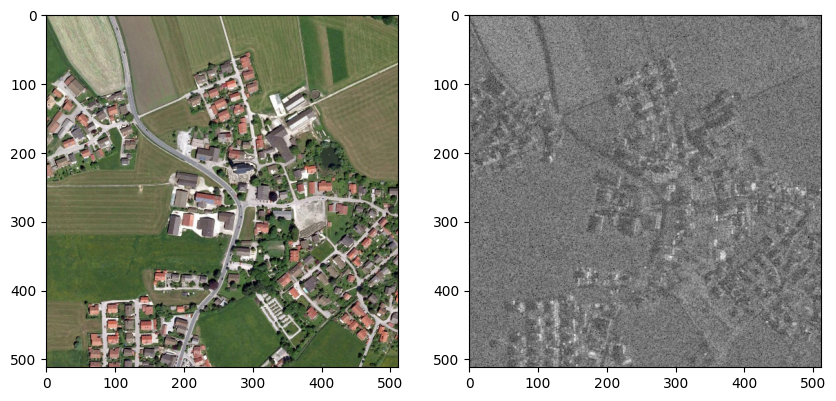

In [4]:
input_path = "../../dataset/clip_T1.mat"
data = scipy.io.loadmat(input_path)

guide = data['guide']
noisy = data['noisy']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(guide)
plt.subplot(1, 2, 2)
plt.imshow(T(noisy), cmap='gray')

In [5]:
opt_rgb = jnp.array(guide) / 255.0
sar = T(noisy)

opt_gray = rgb2gray(opt_rgb)
opt_lab = rgb2lab(opt_rgb)

print(sar.shape, opt_gray.shape, opt_lab.shape, opt_rgb.shape)

(512, 512, 1) (512, 512, 1) (512, 512, 3) (512, 512, 3)


In [6]:
params_texture_descriptor = {
    'opt': opt_lab,
    'radius': 7,
}

params_mubf = {
    # 'target': S,
    'guides': [opt_gray, sar],  # (H, W, 1)
    'sigma_spatial': 5,
    'sigma_guides': [0.001, 0.01],
    'alpha': 5,
    'n_iterations': 150,
    'n_blocks': 10
}

params_despeckling = {
    "sar": sar,
    # "descriptor": S_mubf,
    "sigma_distance": 3,
    "radius_despeckling": 30,
    "n_blocks": 20
}

### Compute texture descriptor

In [7]:
S = sar_despeckling._step1_compute_texture_descriptor(**params_texture_descriptor)

INFO:root:Computing texture descriptor...
INFO:root:Warning: NaN values found in texture descriptor. Replacing with zeros.
INFO:root:Texture descriptor computed in 7.24 seconds.


### MUBF and Despeckling

In [8]:
params_mubf['target'] = S

gamma_opt_list = [0., 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]

results = {}
for gamma_opt in tqdm(gamma_opt_list):
    params_mubf['gamma_guides'] = [gamma_opt, 1.0]
    S_mubf = sar_despeckling._step2_filter_texture_descriptor(**params_mubf)
    print(f'Error for gamma_guides={params_mubf["gamma_guides"]}:', sar_despeckling.error[-1])

    params_despeckling['descriptor'] = S_mubf
    sar_filtered = sar_despeckling._step3_despeckle(**params_despeckling)

    results[gamma_opt] = sar_filtered

Iterations: 100%|██████████| 150/150 [04:03<00:00,  1.63s/it]
INFO:root:Texture descriptor filtering completed in 244.35 seconds.
INFO:root:Despeckling SAR image...


Error for gamma_guides=[0.0, 1.0]: 0.0


Despeckling: 100%|██████████| 400/400 [00:08<00:00, 44.57block/s]
INFO:root:Despeckling completed in 9.17 seconds.
Iterations: 100%|██████████| 150/150 [04:01<00:00,  1.61s/it]
INFO:root:Texture descriptor filtering completed in 241.85 seconds.
INFO:root:Despeckling SAR image...


Error for gamma_guides=[0.001, 1.0]: 0.07310068607330322


Despeckling: 100%|██████████| 400/400 [00:05<00:00, 67.54block/s]
INFO:root:Despeckling completed in 5.93 seconds.
Iterations: 100%|██████████| 150/150 [04:07<00:00,  1.65s/it]
INFO:root:Texture descriptor filtering completed in 247.81 seconds.
INFO:root:Despeckling SAR image...


Error for gamma_guides=[0.005, 1.0]: 0.351913720369339


Despeckling: 100%|██████████| 400/400 [00:05<00:00, 75.22block/s]
INFO:root:Despeckling completed in 5.32 seconds.
Iterations: 100%|██████████| 150/150 [04:15<00:00,  1.70s/it]
INFO:root:Texture descriptor filtering completed in 255.72 seconds.
INFO:root:Despeckling SAR image...


Error for gamma_guides=[0.01, 1.0]: 0.6725751161575317


Despeckling: 100%|██████████| 400/400 [00:05<00:00, 68.58block/s]
INFO:root:Despeckling completed in 5.84 seconds.
Iterations: 100%|██████████| 150/150 [03:59<00:00,  1.59s/it]
INFO:root:Texture descriptor filtering completed in 239.11 seconds.
INFO:root:Despeckling SAR image...


Error for gamma_guides=[0.05, 1.0]: 2.4795968532562256


Despeckling: 100%|██████████| 400/400 [00:05<00:00, 78.09block/s]
INFO:root:Despeckling completed in 5.13 seconds.
Iterations: 100%|██████████| 150/150 [03:51<00:00,  1.54s/it]
INFO:root:Texture descriptor filtering completed in 231.41 seconds.
INFO:root:Despeckling SAR image...


Error for gamma_guides=[0.1, 1.0]: 3.7231621742248535


Despeckling: 100%|██████████| 400/400 [00:05<00:00, 71.89block/s]
INFO:root:Despeckling completed in 5.57 seconds.
Iterations: 100%|██████████| 150/150 [03:54<00:00,  1.56s/it]
INFO:root:Texture descriptor filtering completed in 234.20 seconds.
INFO:root:Despeckling SAR image...


Error for gamma_guides=[0.5, 1.0]: 6.089992523193359


Despeckling: 100%|██████████| 400/400 [00:05<00:00, 78.74block/s]
INFO:root:Despeckling completed in 5.09 seconds.
Iterations: 100%|██████████| 150/150 [04:00<00:00,  1.60s/it]
INFO:root:Texture descriptor filtering completed in 240.22 seconds.
INFO:root:Despeckling SAR image...


Error for gamma_guides=[1.0, 1.0]: 6.553075790405273


Despeckling: 100%|██████████| 400/400 [00:05<00:00, 79.07block/s]
INFO:root:Despeckling completed in 5.06 seconds.
100%|██████████| 8/8 [33:01<00:00, 247.73s/it]


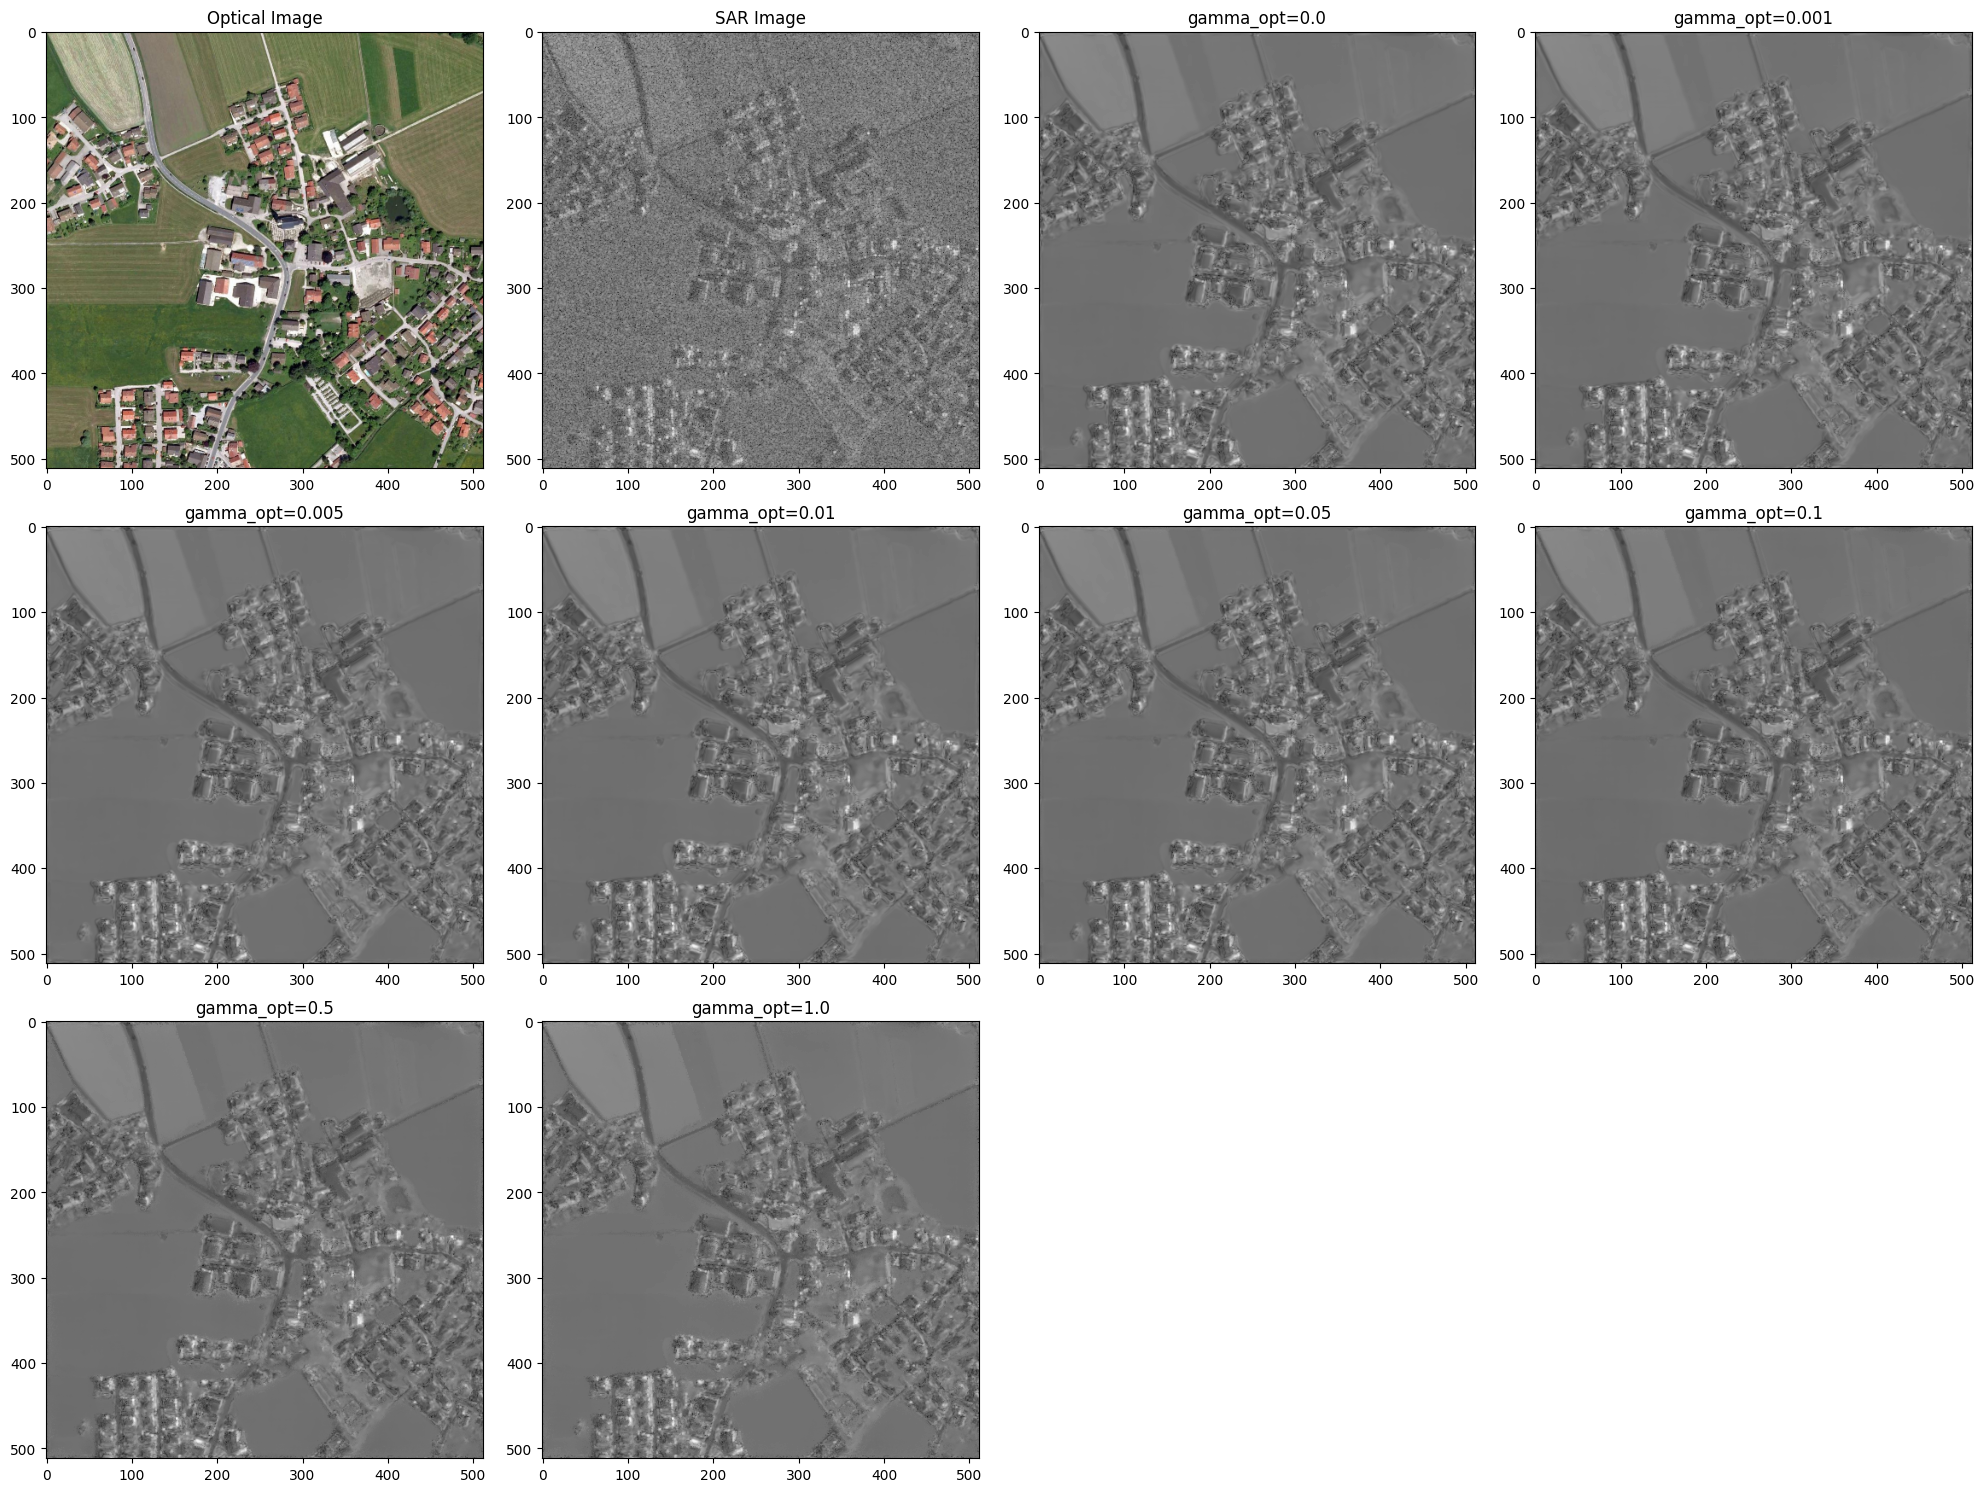

In [9]:
plt.figure(figsize=(20, 15))
plt.subplot(3, 4, 1)
plt.imshow(opt_rgb)
plt.title('Optical Image')
plt.subplot(3, 4, 2)
plt.imshow(sar, cmap='gray')
plt.title('SAR Image')
for i, (gamma_opt, sar_filtered) in enumerate(results.items()):
    plt.subplot(3, 4, i + 3)
    plt.imshow(sar_filtered, cmap='gray')
    plt.title(f'gamma_opt={gamma_opt}')
plt.tight_layout()
# plt.savefig(f'/home/nus/Downloads/{name}.png', dpi=300)

### Test global

In [10]:
# sar_filtered = sar_despeckling.run(sar, 
#                                    opt_rgb,
#                                    radius_descriptor=21,
#                                    sigma_s=5,
#                                    sigma_l_opt=0.1,
#                                    sigma_l_sar=0.1,
#                                    alpha_ubf=1.0,
#                                    n_iter=30,
#                                    sigma_d=1.5,
#                                    radius_despeckling=50,
#                                    n_blocks=10)

In [11]:
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 3, 1)
# plt.imshow(opt)
# plt.title('Optical Image')
# plt.subplot(1, 3, 2)
# plt.imshow(sar, cmap='gray')
# plt.title('SAR Image')
# plt.subplot(1, 3, 3)
# plt.imshow(sar_filtered, cmap='gray')
# plt.title('Filtered SAR Image')
# plt.tight_layout()

In [12]:
# plt.plot(sar_despeckling.error)